In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
!pip install -q libtiff
!pip install -q tqdm

In [5]:
# import the necessary packages
import matplotlib.pyplot as plt
import sys
import os
from pathlib import Path
from libtiff import TIFF
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display
import tensorflow as tf
from sklearn.metrics import balanced_accuracy_score
from keras.optimizers import SGD, RMSprop, Adam
from keras import optimizers, Model, callbacks
from sklearn.metrics import mean_squared_error
from keras.utils import plot_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler

**Класс Dataset**   

Предназначен для работы с наборами данных, хранящихся на Google Drive, обеспечивает чтение изображений и соответствующих меток, а также формирование пакетов (батчей).

In [6]:
class Dataset:
    def __init__(self, name, gdrive_dir):
        self.name = name
        self.is_loaded = False
        p = Path("/content/drive/MyDrive/" + gdrive_dir + name + '.npz') 
        if p.exists():
            print(f'[INFO] Loading dataset {self.name} from npz...')
            np_obj = np.load(str(p)) 
            self.images = np_obj['data']
            self.labels = np_obj['labels']
            self.n_files = self.images.shape[0]
            self.is_loaded = True
            print(f'[INFO] Done. Dataset {name} consists of {self.n_files} images.')

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]
  
    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.array(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]
    

**Класс Model**   

Предназначен для работы с нейросетью. Обеспечивает загрузку, обучение, тестирование и сохранение нейронной сети, отображение дополнительной информации об алгоритме обучения.

In [12]:
class Model:

    def __init__(self):
        chanDim = -1
        self.model = tf.keras.models.Sequential(
            [tf.keras.layers.Conv2D(8, (3, 3), padding="same", activation='relu',
          input_shape=(224, 224, 3)),
          tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
          tf.keras.layers.Conv2D(64, (3, 3), padding="same" , activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)), #, kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
          tf.keras.layers.MaxPooling2D(data_format='channels_last'),

          tf.keras.layers.Conv2D(128, (3, 3), padding="same" , activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)), #, kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
          tf.keras.layers.MaxPooling2D(data_format='channels_last'),

          tf.keras.layers.Conv2D(256, (3, 3), padding="same", activation='relu'),    
          tf.keras.layers.MaxPooling2D(data_format='channels_last'),
          
          tf.keras.layers.Conv2D(512, (3, 3), padding="same", activation='relu'),
          tf.keras.layers.MaxPooling2D(data_format='channels_last'),
          tf.keras.layers.Dropout(0.5),

          tf.keras.layers.Flatten(),

          tf.keras.layers.Dense(1000, kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
          tf.keras.layers.Activation("relu"),
          tf.keras.layers.Dropout(0.3),

          tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
          tf.keras.layers.Activation("relu"),
          tf.keras.layers.Dropout(0.3),

          tf.keras.layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
          tf.keras.layers.Activation("relu"),
          tf.keras.layers.Dropout(0.3),
          
          tf.keras.layers.Dense(9),
          tf.keras.layers.Activation("softmax")
          ])

        self.save_dir = "/content/drive/MyDrive/nn_tasks/" 


    def save_model(self, name: str):
        # save model to SAVE_DIR folder on gdrive with name 'name'
        #self.save_dir += name
        self.model.save(self.save_dir + "model-res/" + name + "_model.h5")
        self.model.save_weights(self.save_dir + "model-res/" + name + "_model-weights.h5")
        plot_model(self.model, to_file=self.save_dir + "model-res/" + name + "_m.png", show_shapes=True)     


    def load(self, name: str, is_checkpoint=False):
        p1 = Path(self.save_dir + "model-res/"  + name + ".h5") 
        p2 = Path(self.save_dir + "model-res/best_checkpoint/")
      
        self.model = None
        if is_checkpoint and p2.exists():
          self.model = tf.keras.models.load_model(p2)
        elif p1.exists():
          self.model = tf.keras.models.load_model(p1)
        return model 


    def train(self, dataset: Dataset, is_showing_history=True):
        # you can add some plots for better visualization,
        self.INIT_LR = 6e-4    
        self.EPOCHS = 100
        self.BS = 64

        print(f"[INFO] split and shuffle the data...")
        d_train_images_1, d_train_labels_1 = dataset.random_batch_with_labels(dataset.n_files)
        n_train = int(dataset.n_files * 0.92) 
        
        d_train_images = d_train_images_1[0:n_train]
        d_train_labels = d_train_labels_1[0:n_train]
        #LBL1
        d_val_images = d_train_images_1[n_train:dataset.n_files] 
        d_val_labels = d_train_labels_1[n_train:dataset.n_files]

        #scaler = MinMaxScaler()
        #X = scaler.fit_transform(d_train_images)
        #X_val = scaler.fit_transform(d_val_images)

        optA = Adam(learning_rate=self.INIT_LR)
        self.model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=optA,
          metrics=["accuracy"])

        #LBL2
        checkpoint = callbacks.ModelCheckpoint(self.save_dir + "model-res/best_checkpoint", monitor='val_accuracy', verbose=1, save_best_only=True,
    save_weights_only=False, save_freq='epoch') 
        callbacks_list = [checkpoint]
        #LBL3
        print(f"[INFO] training network...")
        self.History = self.model.fit(d_train_images, d_train_labels, validation_data=(d_val_images, d_val_labels), epochs=self.EPOCHS, batch_size=self.BS, callbacks=callbacks_list)
        print(f'[INFO] training done')
        #LBL4
        self.show_history(str(n_train))
        

    def test_on_dataset(self, dataset: Dataset, limit=None):
        # you can upgrade this code if you want to speed up testing using batches
        predictions = []
        n = dataset.n_files if not limit else int(dataset.n_files * limit)
        for img in tqdm(dataset.images_seq(n), total=n):
            predictions.append(self.test_on_image(img))
        return predictions


    def test_on_image(self, img):
        # todo: replace this code
        prediction = self.model.predict(np.array(img))
        return np.argmax(prediction)


    def evaluate_model(self, dataset: Dataset):
        print("[INFO] evaluating network...")
        result = self.model.evaluate(dataset.images, dataset.labels, batch_size=self.BS)
        print('test loss, test acc:', result)

        predictions = self.model.predict(dataset.images)
        pred = []
        print("MSE  (test_y, predictions)")
        for i in range(0, len(dataset.labels)):
          pred.append(predictions[i].max())
        print(mean_squared_error(dataset.labels, pred, squared=False))


    def show_history(self, size):
        N = np.arange(0, self.EPOCHS)
        plt.style.use("ggplot")
        plt.figure()
        plt.plot(N, self.History.history["loss"], label="train_loss")
        plt.plot(N, self.History.history["accuracy"], label="train_acc")
        plt.plot(N, self.History.history["val_loss"], label="test_loss")
        plt.plot(N, self.History.history["val_accuracy"], label="test_acc")
        plt.title("Training Los")
        plt.xlabel("Epoch #")
        plt.ylabel("Loss, accuracy")
        plt.legend()
        plt.savefig(self.save_dir + "model-res/history_training_on_" + size + "_" + ".png")



In [8]:
PROJECT_DIR = "nn_tasks/"

In [9]:
EVALUATE_ONLY = False
TEST_ON_LARGE_DATASET = True
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')

In [10]:
dataset_test = Dataset('test', PROJECT_DIR)
dataset_train = Dataset('train', PROJECT_DIR)

[INFO] Loading dataset test from npz...
[INFO] Done. Dataset test consists of 4500 images.
[INFO] Loading dataset train from npz...
[INFO] Done. Dataset train consists of 18000 images.


[INFO] split and shuffle the data...
[INFO] training network...
Epoch 1/100
259/259 [==============================] - 25s 94ms/step - loss: 25.2997 - accuracy: 0.2440 - val_loss: 10.9341 - val_accuracy: 0.4236

Epoch 00001: val_accuracy improved from -inf to 0.42361, saving model to /content/drive/MyDrive/nn_tasks/model-res/best_checkpoint
INFO:tensorflow:Assets written to: /content/drive/MyDrive/nn_tasks/model-res/best_checkpoint/assets
Epoch 2/100
259/259 [==============================] - 25s 96ms/step - loss: 9.3074 - accuracy: 0.4808 - val_loss: 5.7297 - val_accuracy: 0.6215

Epoch 00002: val_accuracy improved from 0.42361 to 0.62153, saving model to /content/drive/MyDrive/nn_tasks/model-res/best_checkpoint
INFO:tensorflow:Assets written to: /content/drive/MyDrive/nn_tasks/model-res/best_checkpoint/assets
Epoch 3/100
259/259 [==============================] - 24s 94ms/step - loss: 5.1818 - accuracy: 0.5983 - val_loss: 3.8222 - val_accuracy: 0.5764

Epoch 00003: val_accuracy did n

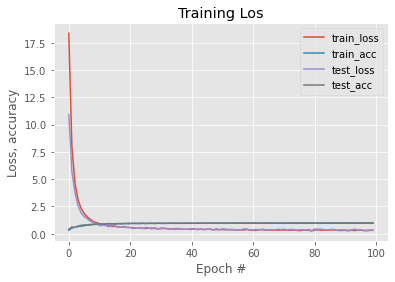

In [13]:
model = Model()
if not EVALUATE_ONLY:
    model.train(dataset_train, is_showing_history=True)
    model.save_model('best')
else:
    model.load('best')

In [14]:
model.evaluate_model(dataset_test)

[INFO] evaluating network...
71/71 [==============================] - 3s 38ms/step - loss: 0.4414 - accuracy: 0.9511
test loss, test acc: [0.4413629472255707, 0.9511111378669739]
MSE  (test_y, predictions)
3.9812546


In [15]:
img, lbl = dataset_test.random_image_with_label()
pred = model.test_on_image([img])

In [16]:
TISSUE_CLASSES[pred], pred, TISSUE_CLASSES[lbl], lbl

('DEB', 2, 'DEB', 2)

In [ ]:
#LOADING MODEL FROM BEST CHECKPOINT
mm = model.load("best_model", is_checkpoint=True)

In [19]:
mm.evaluate_model(dataset_test)

[INFO] evaluating network...
71/71 [==============================] - 2s 24ms/step - loss: 0.4487 - accuracy: 0.9547
test loss, test acc: [0.44866058230400085, 0.9546666741371155]
MSE  (test_y, predictions)
3.9859054


In [20]:
img, lbl = dataset_test.random_image_with_label()
pred = model.test_on_image([img])

In [95]:
TISSUE_CLASSES[pred], pred, TISSUE_CLASSES[lbl], lbl

('STR', 7, 'STR', 7)


Got numpy array of shape (224, 224, 3), and label with code 2.
Label code corresponds to DEB class.


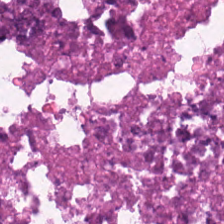

In [ ]:
img, lbl = dataset_train.random_image_with_label()
print()
print(f'Got numpy array of shape {img.shape}, and label with code {lbl}.')
print(f'Label code corresponds to {TISSUE_CLASSES[lbl]} class.')

pil_img = Image.fromarray(img)
IPython.display.display(pil_img)